# Final Project: Prey Predator
## Author: Dor Cohen
## Instractor: Dr Yoav Ram

### **Background**
In class we discussed the simple prey predator model summrized by the lotka-volterra equations which allowed us to  

In this project we will discuss a more complicated scenario where there are 2 populations of predators differnt in their hunting rate. In the begining of this scenrio there is a big population of predator $y_1$ and a small population of $y_2$ but $h_1<h_2$.

In nature scenrio like this happens when there are mutaion which make the hunting rate better or if a invasive species appears.

In [7]:
from functools import partial

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('talk')

import scipy
from scipy.integrate import solve_bvp, solve_ivp, odeint
from ipywidgets import interact

The equations are: 

$\frac{dx}{dt} = bx - (h_1y_1+h_2y_2)x$

$\frac{dy_1}{dt} = \epsilon_1h_1xy_1 - d_1y_1$

$\frac{dy_2}{dt} = \epsilon_2h_2xy_2 -d_2y_2$

Where the parameters are:

x - prey 

b - birth rate of prey

$y_1$ - native predator

$h_1$ - native predator hunting rate

$\epsilon_1$ - native predator "ingestion rate"

$d_1$ - the native predator death rate

$y_2$ - invasive predator

$h_2$ - invasive predator hunting rate

$\epsilon_2$ - invasive predator "ingestion rate"

$d_2$ - the invasive predator death rate


For simplicity I'll assume that the invasive predator has only different hunting rate. The differnet huning rate gives the invasive predator evolutionary advantage  

Therefore, $\epsilon_1=\epsilon_2=\epsilon$ and $d_1=d_2=d$

The equations will be:

$\frac{dx}{dt} = bx - (h_1y_1+h_2y_2)x$

$\frac{dy_1}{dt} = \epsilon h_1xy_1 - dy_1$

$\frac{dy_2}{dt} = \epsilon h_2xy_2 -dy_2$

In [12]:
def dxy1y2dt(t, xy1y2, b, h1, h2, ϵ, d):
    x, y1, y2 = xy1y2
    dx = b * x - (h1*y1+h2*y2)*x
    dy1 = ϵ * h1 * x * y1 - d * y1
    dy2 = ϵ * h2 * x * y2 - d * y2
    return np.array([dx, dy1, dy2])

In [15]:
# model parameters
b = 1
h1 = 0.005
h2 = 0.006
ϵ = 0.8
d = 0.6

steps = 100000 # number integration steps
xy = np.empty((3, steps)) # population array
xy[:,0] = 50, 100, 5
dt = 0.001 # time step for integration
for t in range(1, steps):
    xy[:, t] = xy[:, t-1] + dxy1y2dt(t, xy[:, t-1], b, h1, h2, ϵ, d) * dt
x = xy[0, :]
y1 = xy[1, :]
y2 = xy[2, :]
t = np.arange(0, dt * steps, dt)

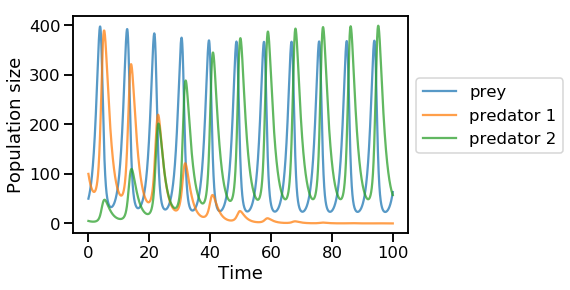

In [16]:
plt.plot(t, x, alpha=0.75, label='prey')
plt.plot(t, y1, alpha=0.75, label='predator 1')
plt.plot(t,y2, alpha=0.75, label='predator 2')
plt.xlabel('Time')
plt.ylabel('Population size')
# bbox_to_anchor places the legend at specific position, in this case outside the plot
plt.legend(bbox_to_anchor=(1, 0.75));